## Analysis of the frame count using the hand annotated regions (Figure 2)

In [2]:
# imports
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from functions_EDX import *

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)


from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.metrics import DistanceMetric
import tifffile as tif

In [2]:
mask_dir = os.path.join(os.getcwd(), os.pardir,'hand_annotated_masks')
file_names = os.listdir(mask_dir)
file_names = [name for name in file_names if name.endswith('tif')]
file_names.sort()
mask_paths = [os.path.join(mask_dir,file_name) for file_name in file_names]


colors = ['w','r','g','b','c','m','y']
newcmap = ListedColormap(colors)
size_xy = 1024   # the spatial resolution
all_masks = np.zeros((size_xy,size_xy),dtype='int')
for i in range(6):
    x = tif.imread(mask_paths[i])
    x = rebin_XY(x).astype('bool')
    #print(np.unique(x*(i+1)))
    all_masks = all_masks + x*(i+1)


In [ ]:
frames = [i for i in range(2,102,2)]
InnerOuterRatios = np.zeros(len(frames))

all_embeddings = []
all_y = []
for file_idx in range(len(frames)):
    print('%03d frames' % frames[file_idx])
    spectrum_folder = '/Volumes/Microscopy4/EDX_data/old_datasets/Spectrum2D_extendedGauss1_3_5/' 
    # change to '/path/to/preprocessedData'
    
    file_names = []
    tmp = os.listdir(spectrum_folder)
    for filename in tmp:
        if filename.endswith('.npz'):
            file_names.append(filename)
    
    file_names = sorted(file_names)
    files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]
    spectrum_2D = np.load(files[file_idx])['spectrum_2D']
    size_xy = 1024

    
    # The distances to the mean
    all_idx = all_masks.reshape((size_xy**2))
    mean_spectrum_nonAnnotated =  spectrum_2D[all_idx==0,:].mean(axis=0)
    num_annotated = np.sum(all_idx>0)

    distancesToMean = []
    for i in range(1,7):
        
        class_count = np.sum(all_idx==i)
        #print("Class %02d has %05d annotations" % (i,class_count)) 
        spectra_of_class = spectrum_2D[all_idx==i,:]
        distances_to_class = np.zeros((class_count))
        for j in range(class_count):
            distances_to_class[j] = euc(mean_spectrum_nonAnnotated,spectra_of_class[j,:])            
        distancesToMean.append(distances_to_class)

    
    # inner outer ratio 
    annotated_idx = np.sort(all_idx[all_idx>0])
    x = np.array([i for i in range(num_annotated)])
    y = MinMaxScaler().fit_transform(np.hstack(distancesToMean).reshape(-1, 1))
    all_y.append(y)
    
    similarity_dissimilarity_ratio = compute_inner_outer_similarity_with_distances(y,np.sort(all_idx[all_idx>0]))
    print("Ratio:", similarity_dissimilarity_ratio)
    InnerOuterRatios[file_idx] = similarity_dissimilarity_ratio

#np.savez_compressed('InnerOuterRatios',InnerOuterRatios=InnerOuterRatios) 

### Load precomputed metrics and set plot parameters

In [3]:
InnerOuterRatios = np.load('../precomputed/InnerOuterRatios.npz')['InnerOuterRatios']

# matplotlib parameters
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# this one makes the ticks into text in the exported svgs
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

### plot the innerclass/outerclass ratio against frame count

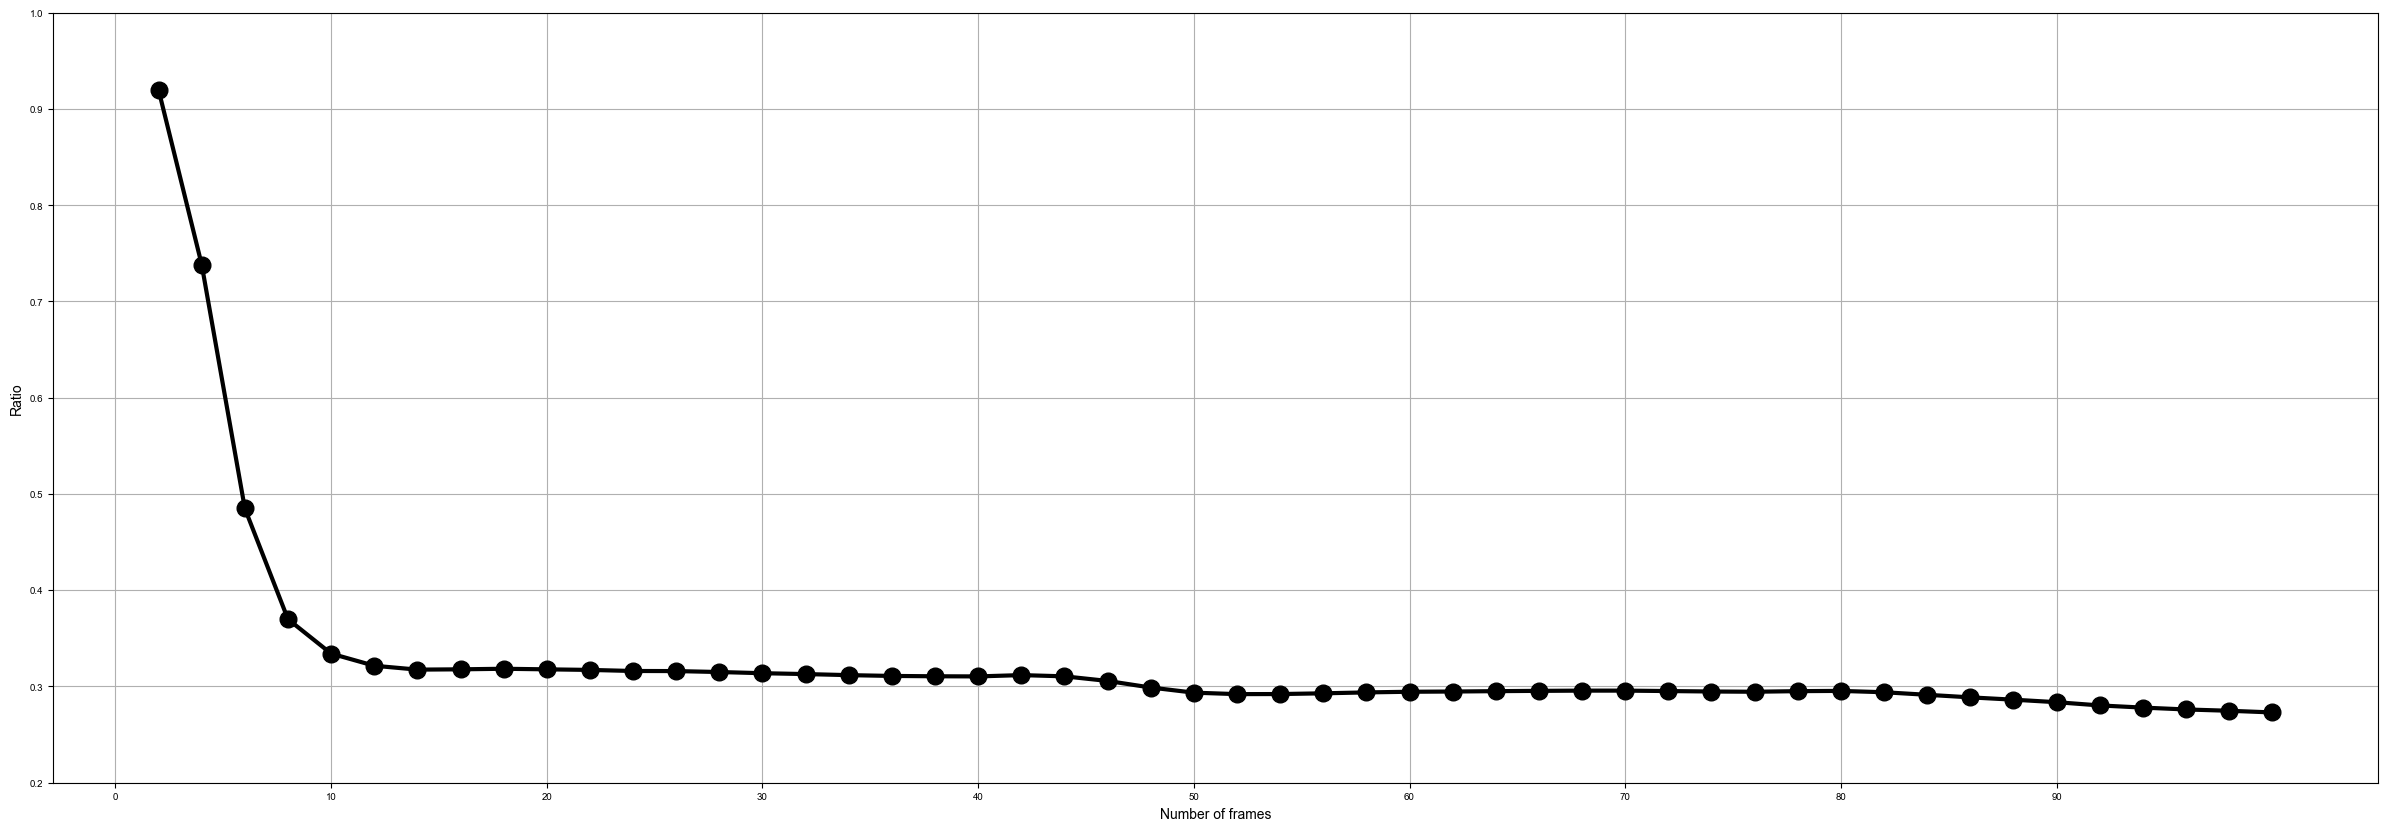

In [4]:
f,ax = plt.subplots(figsize=(30,10))
#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.rcParams.update({'font.size': 25})

ax.plot(range(2,102,2),InnerOuterRatios,'ko-',markersize=12,linewidth=3)
#ax.plot(range(4,102,2),np.diff(InnerOuterRatios),'rx-',markersize=12)
ax.set_xticks(range(0,100,10))

ax.grid(True)
ax.set_ylim(0.2,1)
ax.set_ylabel('Ratio')
ax.set_xlabel('Number of frames')
#plt.savefig("Exports/frame_count.png",dpi=300) #,bbox_inches='tight')
#plt.savefig("Exports/frame_count.svg")
plt.show()


### All in one plot (Figure 2)

002 frames
(1048576, 250)
020 frames
(1048576, 250)
100 frames
(1048576, 250)


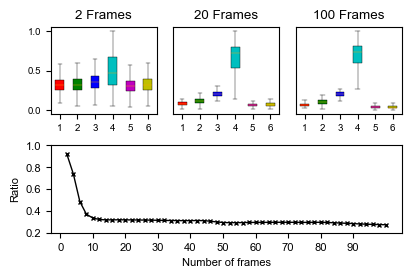

In [16]:
frames = [i for i in range(2,102,2)]
fig = plt.figure(layout="constrained",figsize=(4,4*2/3)) #plt.subplots(2,3,figsize=(15,15))
gs = GridSpec(2, 3, figure=fig)
    
ax0 = fig.add_subplot(gs[0,0])   
ax1 = fig.add_subplot(gs[0,1])  
ax2 = fig.add_subplot(gs[0,2])   
ax3 = fig.add_subplot(gs[1,:])   

axes = [ax0,ax1,ax2]

# Set font properties
font = {'family': 'Arial', 'size': 8}
plt.rc('font', **font)

for idx,file_idx in enumerate([0,9,49]):
    print('%03d frames' % frames[file_idx])
    spectrum_folder = '/Volumes/Microscopy4/EDX_data/old_datasets/Spectrum2D_extendedGauss1_3_5/' 
    # change to '/path/to/preprocessedData'
    file_names = []
    tmp = os.listdir(spectrum_folder)
    for filename in tmp:
        if filename.endswith('.npz'):
            file_names.append(filename)
    
    file_names = sorted(file_names)
    files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]
    spectrum_2D = np.load(files[file_idx])['spectrum_2D'][:,:250]
    print(spectrum_2D.shape)
    size_xy = 1024
    #print(files[file_idx])
    
    # The distances to the mean
    all_idx = all_masks.reshape((size_xy**2))
    mean_spectrum_nonAnnotated =  spectrum_2D[all_idx==0,:].mean(axis=0)
    num_annotated = np.sum(all_idx>0)
    distancesToMean = []
    
    
    for i in range(1,7):
        class_count = np.sum(all_idx==i)
        #print("Class %02d has %05d annotations" % (i,class_count)) 
        spectra_of_class = spectrum_2D[all_idx==i,:]
        distances_to_class = np.zeros((class_count))
        for j in range(class_count):
            distances_to_class[j] = euc(mean_spectrum_nonAnnotated,spectra_of_class[j,:])            
        distancesToMean.append(distances_to_class)
    
    # inner outer ratio thing
    annotated_idx = np.sort(all_idx[all_idx>0])

    # subsample
    #annotated_idx  = np.random.choice(annotated_idx, size=6000, replace=False)
    
    x = np.array([i for i in range(num_annotated)])
    y = MinMaxScaler().fit_transform(np.hstack(distancesToMean).reshape(-1, 1))
    

    # box plot
    all_data = [y[annotated_idx==i].ravel() for i in range(1,7)]
    labels = ['%01d' % i for i in range(1,7)]

    # properties
    # Customizing boxplot properties
    boxprops = dict(color='black', linewidth=0.3)  # Change box outline color and thickness
    medianprops = dict(color='orange', linewidth=0.3)  # Change median line color and thickness
    flierprops = dict(marker='o', markersize=0, markerfacecolor='black')  # Customize outlier markers
    capprops = dict(color='black', linewidth=0.3)  # Change whisker caps color and thickness
    whiskerprops = dict(color='black', linewidth=0.3)  # Change whisker color and thickness

    bplot = axes[idx].boxplot(all_data, notch=False,  vert=True,  patch_artist=True,  labels=labels,
                               boxprops=boxprops, 
                               medianprops=medianprops, 
                               flierprops=flierprops, 
                               capprops=capprops, 
                               whiskerprops=whiskerprops)
    axes[idx].set_title('%d Frames' % (frames[file_idx]))
    
    
    for patch, color in zip(bplot['boxes'], colors[1:]):
        patch.set_facecolor(color)
    
    # adding horizontal grid lines
    axes[idx].yaxis.grid(False)

    # remove redundant ticks to save space
    if idx>0:
        axes[idx].set_yticks([])

    #plt.savefig("Exports/frame_count_box_%03d.svg" % (frames[file_idx]))


ax3.plot(range(2,102,2),InnerOuterRatios,'kx-',markersize=3,fillstyle='none',linewidth=1)
#ax.plot(range(4,102,2),np.diff(InnerOuterRatios),'rx-',markersize=12)
ax3.set_xticks(range(0,100,10))
ax3.set_yticks([i/10.0 for i in range(2,12,2)])

ax3.grid(False)
ax3.set_ylim(0.2,1)
ax3.set_ylabel('Ratio',fontsize=8)
ax3.set_xlabel('Number of frames',fontsize=8)


plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.savefig(os.path.join(os.getcwd(), os.pardir,'Results','frame_analysis_overall.png'),dpi=300) #,bbox_inches='tight')
plt.savefig(os.path.join(os.getcwd(), os.pardir,'Results','frame_analysis_overall.svg'))
plt.show()


### PacMAP scatter plot

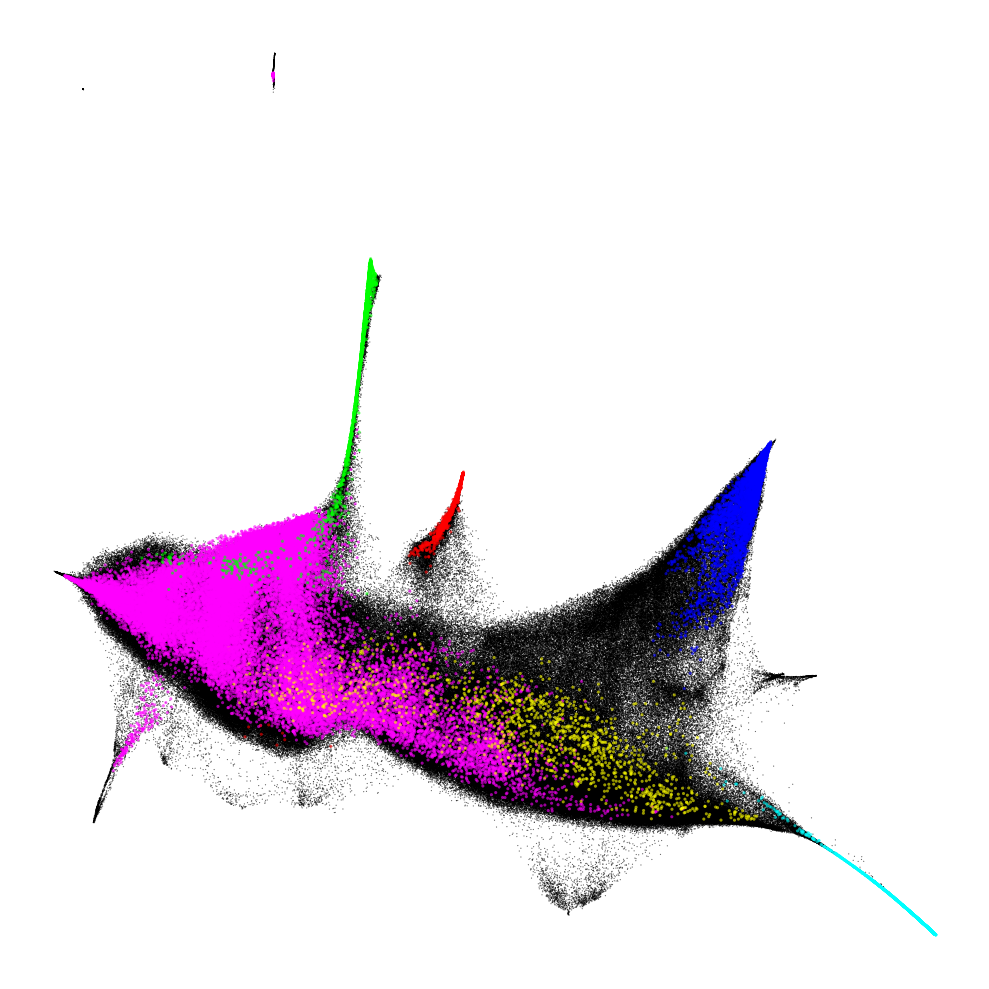

In [25]:
embeddings = np.load(r'../data/Tile_00_PaCMAP_Embeddings.npy')
embeddings = MinMaxScaler().fit_transform(embeddings)

# set colors
colors_arr = np.zeros((embeddings.shape[0], 4))
colors_arr[:,:] = 0
colors = ((1,0,0,0), (0,1,0,0), (0,0,1,0), (0,1,1,0), (1,0,1,0), (1,1,0,0))
mask_dir = (r'../hand_annotated_masks')
files = os.listdir(mask_dir); files.sort()
for c, i in enumerate(files):
    mask = tif.imread(os.path.join(mask_dir, i)).reshape((1024*1024))
    colors_arr[np.where(mask > 0),0] = colors[c][0]
    colors_arr[np.where(mask > 0),1] = colors[c][1]
    colors_arr[np.where(mask > 0),2] = colors[c][2]

# plot settings
marker = '.'
alpha = 0.6
fc = 'white'
colors_arr[:,3] = alpha
avg_colors= colors_arr[:,:3].sum(axis = 1).astype('uint8')

# plot the figure
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
sns.despine(left=True, bottom=True, right=True)
ax.scatter(embeddings[np.where(avg_colors == 0),0], embeddings[np.where(avg_colors == 0),1], c = colors_arr[np.where(avg_colors == 0)], marker = marker, s = 3, edgecolors = 'none')
ax.scatter(embeddings[np.where(avg_colors > 0),0], embeddings[np.where(avg_colors > 0),1], c = colors_arr[np.where(avg_colors > 0)], marker = marker, s = 20, edgecolors = 'none')

ax.set_facecolor(fc)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig(r'../Results/annotated_tile_scatter.png',dpi=300)
plt.show()